In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from transformers import BertTokenizer

In [2]:
train_dir = "/Users/iqbaljanitra/Documents/Face Emotion Prediction/archive-6/train"
test_dir = "/Users/iqbaljanitra/Documents/Face Emotion Prediction/archive-6/test"

In [3]:
img_size = 48

In [4]:
train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [5]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [6]:
checkpoint = ModelCheckpoint('bestmodelprediction.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

In [7]:
input_layer = Input(shape=(48, 48, 1))
conv1 = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv1)
batch_norm1 = BatchNormalization()(conv2)
maxpool1 = MaxPool2D(pool_size=(2, 2))(batch_norm1)
dropout1 = Dropout(0.25)(maxpool1)

conv3 = Conv2D(128, (5, 5), padding='same', activation='relu')(dropout1)
batch_norm2 = BatchNormalization()(conv3)
maxpool2 = MaxPool2D(pool_size=(2, 2))(batch_norm2)
dropout2 = Dropout(0.25)(maxpool2)

conv4 = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(dropout2)
batch_norm3 = BatchNormalization()(conv4)
maxpool3 = MaxPool2D(pool_size=(2, 2))(batch_norm3)
dropout3 = Dropout(0.25)(maxpool3)

conv5 = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(dropout3)
batch_norm4 = BatchNormalization()(conv5)
maxpool4 = MaxPool2D(pool_size=(2, 2))(batch_norm4)
dropout4 = Dropout(0.25)(maxpool4)

flatten = Flatten()(dropout4)
dense1 = Dense(256, activation='relu')(flatten)
batch_norm5 = BatchNormalization()(dense1)
dropout5 = Dropout(0.25)(batch_norm5)

dense2 = Dense(512, activation='relu')(dropout5)
batch_norm6 = BatchNormalization()(dense2)
dropout6 = Dropout(0.25)(batch_norm6)

output_layer = Dense(7, activation='softmax')(dropout6)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-05-03 11:47:17.117190: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-03 11:47:17.117599: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0     

/Users/iqbaljanitra/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
epochs = 45
batch_size = 254

In [9]:
history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator, callbacks=[checkpoint, reduce_lr])

Epoch 1/45


2023-05-03 11:47:17.634588: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-03 11:47:18.187219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


359/359 [==============================] - ETA: 0s - loss: 9.1524 - accuracy: 0.2037

2023-05-03 11:48:07.108558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 8.68637, saving model to bestmodelprediction.h5
359/359 [==============================] - 51s 138ms/step - loss: 9.1524 - accuracy: 0.2037 - val_loss: 8.6864 - val_accuracy: 0.2472 - lr: 1.0000e-04
Epoch 2/45
359/359 [==============================] - ETA: 0s - loss: 8.0620 - accuracy: 0.2538
Epoch 2: val_loss improved from 8.68637 to 7.48385, saving model to bestmodelprediction.h5
359/359 [==============================] - 49s 136ms/step - loss: 8.0620 - accuracy: 0.2538 - val_loss: 7.4838 - val_accuracy: 0.2647 - lr: 1.0000e-04
Epoch 3/45
359/359 [==============================] - ETA: 0s - loss: 7.0402 - accuracy: 0.2902
Epoch 3: val_loss improved from 7.48385 to 6.49336, saving model to bestmodelprediction.h5
359/359 [==============================] - 49s 136ms/step - loss: 7.0402 - accuracy: 0.2902 - val_loss: 6.4934 - val_accuracy: 0.3073 - lr: 1.0000e-04
Epoch 4/45
359/359 [==============================] - ETA: 0s - loss: 6.0419 - accura

Text(0.5, 0, 'Epoch')

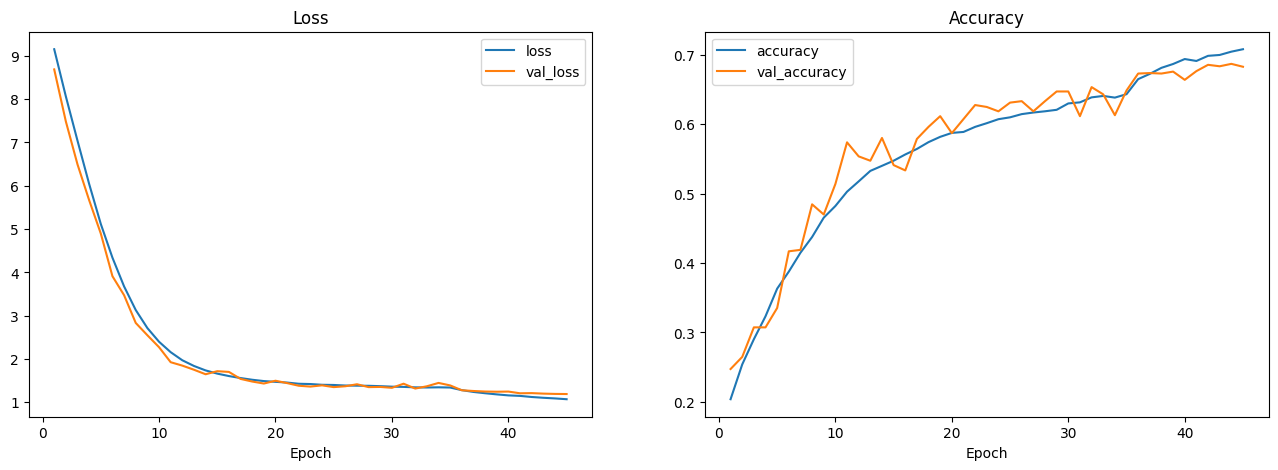

In [11]:
epoch=45

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')